In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import yaml
import torch
import pandas as pd
import cv2
import numpy as np
import torch.utils.data
import torch.nn as nn
import torch.optim as optim

from glob import glob
from tqdm import tqdm
from collections import OrderedDict
from albumentations.augmentations import transforms
from sklearn.model_selection import train_test_split
from albumentations.core.composition import Compose, OneOf
#from train import train, validate
#from source.network import UNetPP
#from source.dataset import DataSet

In [ ]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, img_ids, img_dir, mask_dir, img_ext, mask_ext, transform=None):
        self.img_ids = img_ids
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_ext = img_ext
        self.mask_ext = mask_ext
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]

        img = cv2.imread(os.path.join(self.img_dir, img_id + self.img_ext))

        mask = []
        mask.append(cv2.imread(os.path.join(self.mask_dir,
                                            img_id + self.mask_ext), cv2.IMREAD_GRAYSCALE)[..., None])
        mask = np.dstack(mask)

        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        img = img.astype('float32') / 255
        img = img.transpose(2, 0, 1)
        mask = mask.astype('float32') / 255
        mask = mask.transpose(2, 0, 1)

        return img, mask, {'img_id': img_id}



In [ ]:
import torch
from torch import nn


class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out


class UNetPP(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output


In [ ]:
import torch


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)


In [ ]:
import os
import yaml
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from glob import glob
from tqdm import tqdm
from collections import OrderedDict
#from source.utils import iou_score, AverageMeter
from albumentations import Resize
from albumentations.augmentations import transforms
from sklearn.model_selection import train_test_split
from albumentations.core.composition import Compose, OneOf
from albumentations.augmentations.geometric.rotate import RandomRotate90
#from source.network import UNetPP
#from source.dataset import DataSet


def train(deep_sup, train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    model.train()

    pbar = tqdm(total=len(train_loader))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for input, target, _ in train_loader:
        input = input.to(device)
        target = target.to(device)

        # compute output
        if deep_sup:
            outputs = model(input)
            loss = 0
            for output in outputs:
                loss += criterion(output, target)
            loss /= len(outputs)
            iou = iou_score(outputs[-1], target)
        else:
            output = model(input)
            loss = criterion(output, target)
            iou = iou_score(output, target)

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_meters['loss'].update(loss.item(), input.size(0))
        avg_meters['iou'].update(iou, input.size(0))

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


def validate(deep_sup, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    # switch to evaluate mode
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input, target, _ in val_loader:
            input = input.to(device)
            target = target.to(device)

            # compute output
            if deep_sup:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                iou = iou_score(outputs[-1], target)
            else:
                output = model(input)
                loss = criterion(output, target)
                iou = iou_score(output, target)

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


In [ ]:
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

#from source.network import UNetPP
from argparse import ArgumentParser
from albumentations import Resize
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose


val_transform = Compose([
    Resize(256, 256),
    transforms.Normalize(),
])


def image_loader(image_name):
    img = cv2.imread(image_name)
    img = val_transform(image=img)["image"]
    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)

    return img

In [ ]:
extn= '.png'
epochs= 100
im_width= 384
im_height= 288
model_path =  '/content/drive/MyDrive/IzhanResearch/output/model.pth'
log_path =  '/content/drive/MyDrive/IzhanResearch/output/logs.csv'
image_path = '/content/drive/MyDrive/IzhanResearch/Original'
mask_path = '/content/drive/MyDrive/IzhanResearch/GroundTruth'
output_path = '/content/drive/MyDrive/IzhanResearch/output/prediction.png'

## Create log file

In [ ]:
log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('iou', []),
    ('val_loss', []),
    ('val_iou', []),
])

best_iou = 0
trigger = 0

## Split images into train and validation set

In [ ]:
extn_ = f"*{extn}"
img_ids = glob(os.path.join(image_path, extn_))
img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]
#print(len(img_ids))


In [ ]:
#test_ids = img_ids[-60:]
#img_ids = img_ids[:-60]
#print(test_ids)

In [ ]:
#train_img_ids
train_img_ids, val_img_ids = train_test_split(img_ids, test_size=0.2)

## Define data transformations

In [ ]:
#!pip install -q albumentations==0.5.2
import albumentations as A
from albumentations import Compose, OneOf, transforms


In [ ]:
train_transform = Compose([
    A.RandomRotate90(),
    #A.HorizontalFlip(),
    #A.VerticalFlip(),
    OneOf([
        transforms.HueSaturationValue(),
        #A.RandomBrightness(limit = 0.5),
        #transforms.RandomContrast(),
    ], p=1),
    A.Resize(256, 256),
    transforms.Normalize(),
])

val_transform = Compose([
    A.Resize(256, 256),
    transforms.Normalize(),
])

## Create train and validation dataset

In [ ]:
train_dataset = DataSet(
    img_ids=train_img_ids,
    img_dir=image_path,
    mask_dir=mask_path,
    img_ext=extn,
    mask_ext=extn,
    transform=train_transform)

val_dataset = DataSet(
    img_ids=val_img_ids,
    img_dir=image_path,
    mask_dir=mask_path,
    img_ext=extn,
    mask_ext=extn,
    transform=val_transform)

## Create train and validation data loaders

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=10,
    shuffle=False,
    drop_last=False)

In [ ]:
train_loader

## Create the model object

In [ ]:
# Create model object
model = UNetPP(1, 3, True)

# Port model to GPU if it is available
if torch.cuda.is_available():
    model.cuda()

# Define Loss Function
criterion = nn.BCEWithLogitsLoss()
params = filter(lambda p: p.requires_grad, model.parameters())

# Define Optimizer
optimizer = optim.Adam(params, lr=1e-3, weight_decay=1e-4)

## Run the train loop

In [ ]:
for epoch in range(epochs):
    print(f'Epoch [{epoch}/{epochs}]')

    # train for one epoch
    train_log = train(True, train_loader, model, criterion, optimizer)
    # evaluate on validation set
    val_log = validate(True, val_loader, model, criterion)

    print('loss %.4f - iou %.4f - val_loss %.4f - val_iou %.4f'
              % (train_log['loss'], train_log['iou'], val_log['loss'], val_log['iou']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])

    pd.DataFrame(log).to_csv(log_path, index=False)

    trigger += 1

    if val_log['iou'] > best_iou:
        torch.save(model.state_dict(), model_path)
        best_iou = val_log['iou']
        print("=> saved best model")
        trigger = 0

Epoch [0/100]


100%|██████████| 13/13 [01:28<00:00,  6.84s/it, loss=0.413, iou=1.79e-10]


loss 0.4793 - iou 0.0240 - val_loss 0.4133 - val_iou 0.0000
=> saved best model
Epoch [1/100]


100%|██████████| 13/13 [00:02<00:00,  4.39it/s, loss=0.347, iou=1.79e-10]


loss 0.3544 - iou 0.0009 - val_loss 0.3470 - val_iou 0.0000
Epoch [2/100]


100%|██████████| 13/13 [00:03<00:00,  4.25it/s, loss=0.307, iou=1.79e-10]


loss 0.3005 - iou 0.0021 - val_loss 0.3065 - val_iou 0.0000
Epoch [3/100]


100%|██████████| 13/13 [00:02<00:00,  4.35it/s, loss=0.319, iou=1.79e-10]


loss 0.2764 - iou 0.0006 - val_loss 0.3185 - val_iou 0.0000
Epoch [4/100]


100%|██████████| 13/13 [00:03<00:00,  4.21it/s, loss=0.264, iou=1.79e-10]


loss 0.2638 - iou 0.0007 - val_loss 0.2641 - val_iou 0.0000
Epoch [5/100]


100%|██████████| 13/13 [00:03<00:00,  4.25it/s, loss=0.261, iou=1.79e-10]


loss 0.2571 - iou 0.0005 - val_loss 0.2605 - val_iou 0.0000
Epoch [6/100]


100%|██████████| 13/13 [00:02<00:00,  4.34it/s, loss=0.262, iou=1.79e-10]


loss 0.2552 - iou 0.0000 - val_loss 0.2624 - val_iou 0.0000
Epoch [7/100]


100%|██████████| 13/13 [00:03<00:00,  4.32it/s, loss=0.261, iou=1.79e-10]


loss 0.2575 - iou 0.0000 - val_loss 0.2606 - val_iou 0.0000
Epoch [8/100]


100%|██████████| 13/13 [00:03<00:00,  4.31it/s, loss=0.262, iou=1.79e-10]


loss 0.2483 - iou 0.0002 - val_loss 0.2625 - val_iou 0.0000
Epoch [9/100]


100%|██████████| 13/13 [00:03<00:00,  4.32it/s, loss=0.266, iou=1.79e-10]


loss 0.2448 - iou 0.0036 - val_loss 0.2664 - val_iou 0.0000
Epoch [10/100]


100%|██████████| 13/13 [00:02<00:00,  4.36it/s, loss=0.265, iou=0.00322]


loss 0.2471 - iou 0.0169 - val_loss 0.2653 - val_iou 0.0032
=> saved best model
Epoch [11/100]


100%|██████████| 13/13 [00:02<00:00,  4.38it/s, loss=0.244, iou=1.79e-10]


loss 0.2444 - iou 0.0024 - val_loss 0.2437 - val_iou 0.0000
Epoch [12/100]


100%|██████████| 13/13 [00:03<00:00,  4.29it/s, loss=0.24, iou=0.0486]


loss 0.2403 - iou 0.0400 - val_loss 0.2398 - val_iou 0.0486
=> saved best model
Epoch [13/100]


100%|██████████| 13/13 [00:03<00:00,  4.27it/s, loss=0.237, iou=0.000414]


loss 0.2409 - iou 0.0751 - val_loss 0.2365 - val_iou 0.0004
Epoch [14/100]


100%|██████████| 13/13 [00:02<00:00,  4.35it/s, loss=0.232, iou=0.0135]


loss 0.2389 - iou 0.0393 - val_loss 0.2319 - val_iou 0.0135
Epoch [15/100]


100%|██████████| 13/13 [00:03<00:00,  4.26it/s, loss=0.226, iou=0.0279]


loss 0.2401 - iou 0.0273 - val_loss 0.2261 - val_iou 0.0279
Epoch [16/100]


100%|██████████| 13/13 [00:02<00:00,  4.40it/s, loss=0.244, iou=3.58e-5]


loss 0.2368 - iou 0.0381 - val_loss 0.2440 - val_iou 0.0000
Epoch [17/100]


100%|██████████| 13/13 [00:03<00:00,  4.31it/s, loss=0.258, iou=0.0179]


loss 0.2364 - iou 0.0566 - val_loss 0.2578 - val_iou 0.0179
Epoch [18/100]


100%|██████████| 13/13 [00:02<00:00,  4.34it/s, loss=0.267, iou=0.00196]


loss 0.2336 - iou 0.1187 - val_loss 0.2669 - val_iou 0.0020
Epoch [19/100]


100%|██████████| 13/13 [00:02<00:00,  4.36it/s, loss=0.227, iou=0.354]


loss 0.2306 - iou 0.1409 - val_loss 0.2268 - val_iou 0.3542
=> saved best model
Epoch [20/100]


100%|██████████| 13/13 [00:03<00:00,  4.33it/s, loss=0.274, iou=0.244]


loss 0.2270 - iou 0.1882 - val_loss 0.2738 - val_iou 0.2441
Epoch [21/100]


100%|██████████| 13/13 [00:03<00:00,  4.33it/s, loss=0.231, iou=0.0377]


loss 0.2219 - iou 0.1927 - val_loss 0.2313 - val_iou 0.0377
Epoch [22/100]


100%|██████████| 13/13 [00:02<00:00,  4.38it/s, loss=0.287, iou=0.31]


loss 0.2213 - iou 0.2363 - val_loss 0.2870 - val_iou 0.3097
Epoch [23/100]


100%|██████████| 13/13 [00:02<00:00,  4.37it/s, loss=0.235, iou=0.0857]


loss 0.2237 - iou 0.2295 - val_loss 0.2349 - val_iou 0.0857
Epoch [24/100]


100%|██████████| 13/13 [00:02<00:00,  4.45it/s, loss=0.367, iou=0.166]


loss 0.2224 - iou 0.2123 - val_loss 0.3669 - val_iou 0.1663
Epoch [25/100]


100%|██████████| 13/13 [00:03<00:00,  4.27it/s, loss=0.366, iou=0.118]


loss 0.2210 - iou 0.2422 - val_loss 0.3663 - val_iou 0.1181
Epoch [26/100]


100%|██████████| 13/13 [00:03<00:00,  4.32it/s, loss=0.244, iou=0.108]


loss 0.2216 - iou 0.2351 - val_loss 0.2438 - val_iou 0.1080
Epoch [27/100]


100%|██████████| 13/13 [00:02<00:00,  4.45it/s, loss=0.229, iou=0.417]


loss 0.2185 - iou 0.2499 - val_loss 0.2288 - val_iou 0.4172
=> saved best model
Epoch [28/100]


100%|██████████| 13/13 [00:02<00:00,  4.35it/s, loss=0.347, iou=0.0396]


loss 0.2155 - iou 0.2477 - val_loss 0.3471 - val_iou 0.0396
Epoch [29/100]


100%|██████████| 13/13 [00:02<00:00,  4.41it/s, loss=0.491, iou=0.175]


loss 0.2160 - iou 0.2780 - val_loss 0.4906 - val_iou 0.1753
Epoch [30/100]


100%|██████████| 13/13 [00:03<00:00,  4.22it/s, loss=0.3, iou=0.0579]


loss 0.2124 - iou 0.2968 - val_loss 0.2996 - val_iou 0.0579
Epoch [31/100]


100%|██████████| 13/13 [00:03<00:00,  4.28it/s, loss=0.344, iou=0.217]


loss 0.2118 - iou 0.3055 - val_loss 0.3443 - val_iou 0.2169
Epoch [32/100]


100%|██████████| 13/13 [00:02<00:00,  4.35it/s, loss=0.237, iou=0.365]


loss 0.2054 - iou 0.3511 - val_loss 0.2370 - val_iou 0.3651
Epoch [33/100]


100%|██████████| 13/13 [00:02<00:00,  4.35it/s, loss=0.242, iou=0.107]


loss 0.2071 - iou 0.3192 - val_loss 0.2421 - val_iou 0.1072
Epoch [34/100]


100%|██████████| 13/13 [00:03<00:00,  4.29it/s, loss=0.557, iou=0.164]


loss 0.2042 - iou 0.3551 - val_loss 0.5566 - val_iou 0.1642
Epoch [35/100]


100%|██████████| 13/13 [00:03<00:00,  4.30it/s, loss=0.279, iou=1.79e-10]


loss 0.2068 - iou 0.3577 - val_loss 0.2789 - val_iou 0.0000
Epoch [36/100]


100%|██████████| 13/13 [00:03<00:00,  4.32it/s, loss=0.225, iou=0.345]


loss 0.2001 - iou 0.3795 - val_loss 0.2247 - val_iou 0.3446
Epoch [37/100]


100%|██████████| 13/13 [00:03<00:00,  4.32it/s, loss=0.615, iou=0.171]


loss 0.2041 - iou 0.3903 - val_loss 0.6152 - val_iou 0.1706
Epoch [38/100]


100%|██████████| 13/13 [00:03<00:00,  4.30it/s, loss=0.313, iou=1.79e-10]


loss 0.1997 - iou 0.3844 - val_loss 0.3129 - val_iou 0.0000
Epoch [39/100]


100%|██████████| 13/13 [00:02<00:00,  4.38it/s, loss=0.268, iou=0.377]


loss 0.1975 - iou 0.3938 - val_loss 0.2682 - val_iou 0.3774
Epoch [40/100]


100%|██████████| 13/13 [00:03<00:00,  4.30it/s, loss=0.458, iou=0.164]


loss 0.1977 - iou 0.4042 - val_loss 0.4583 - val_iou 0.1638
Epoch [41/100]


100%|██████████| 13/13 [00:03<00:00,  4.32it/s, loss=0.295, iou=0.0398]


loss 0.1944 - iou 0.4279 - val_loss 0.2953 - val_iou 0.0398
Epoch [42/100]


100%|██████████| 13/13 [00:03<00:00,  4.32it/s, loss=0.222, iou=0.25]


loss 0.1916 - iou 0.4418 - val_loss 0.2219 - val_iou 0.2497
Epoch [43/100]


100%|██████████| 13/13 [00:02<00:00,  4.37it/s, loss=0.221, iou=0.212]


loss 0.1905 - iou 0.4537 - val_loss 0.2212 - val_iou 0.2124
Epoch [44/100]


100%|██████████| 13/13 [00:02<00:00,  4.40it/s, loss=0.442, iou=0.267]


loss 0.1903 - iou 0.4547 - val_loss 0.4418 - val_iou 0.2670
Epoch [45/100]


100%|██████████| 13/13 [00:03<00:00,  4.28it/s, loss=0.249, iou=0.404]


loss 0.1886 - iou 0.4622 - val_loss 0.2495 - val_iou 0.4037
Epoch [46/100]


100%|██████████| 13/13 [00:03<00:00,  4.31it/s, loss=0.237, iou=0.119]


loss 0.1857 - iou 0.4785 - val_loss 0.2368 - val_iou 0.1194
Epoch [47/100]


100%|██████████| 13/13 [00:03<00:00,  4.32it/s, loss=0.291, iou=1.79e-10]


loss 0.1819 - iou 0.5095 - val_loss 0.2905 - val_iou 0.0000
Epoch [48/100]


100%|██████████| 13/13 [00:02<00:00,  4.36it/s, loss=0.298, iou=0.297]


loss 0.1862 - iou 0.4836 - val_loss 0.2983 - val_iou 0.2973
Epoch [49/100]


100%|██████████| 13/13 [00:03<00:00,  4.30it/s, loss=0.304, iou=1.79e-10]


loss 0.1835 - iou 0.4993 - val_loss 0.3038 - val_iou 0.0000
Epoch [50/100]


100%|██████████| 13/13 [00:03<00:00,  4.30it/s, loss=0.247, iou=0.0818]


loss 0.1777 - iou 0.5258 - val_loss 0.2467 - val_iou 0.0818
Epoch [51/100]


100%|██████████| 13/13 [00:03<00:00,  4.32it/s, loss=0.326, iou=1.79e-10]


loss 0.1750 - iou 0.5376 - val_loss 0.3256 - val_iou 0.0000
Epoch [52/100]


100%|██████████| 13/13 [00:02<00:00,  4.35it/s, loss=0.227, iou=0.284]


loss 0.1808 - iou 0.5352 - val_loss 0.2272 - val_iou 0.2836
Epoch [53/100]


100%|██████████| 13/13 [00:02<00:00,  4.38it/s, loss=0.336, iou=1.79e-10]


loss 0.1734 - iou 0.5529 - val_loss 0.3356 - val_iou 0.0000
Epoch [54/100]


100%|██████████| 13/13 [00:02<00:00,  4.44it/s, loss=0.212, iou=0.349]


loss 0.1759 - iou 0.5355 - val_loss 0.2115 - val_iou 0.3490
Epoch [55/100]


100%|██████████| 13/13 [00:02<00:00,  4.38it/s, loss=0.196, iou=0.436]


loss 0.1742 - iou 0.5330 - val_loss 0.1963 - val_iou 0.4362
=> saved best model
Epoch [56/100]


100%|██████████| 13/13 [00:03<00:00,  4.33it/s, loss=0.244, iou=0.122]


loss 0.1738 - iou 0.5726 - val_loss 0.2437 - val_iou 0.1223
Epoch [57/100]


100%|██████████| 13/13 [00:02<00:00,  4.38it/s, loss=0.531, iou=0.223]


loss 0.1685 - iou 0.5793 - val_loss 0.5314 - val_iou 0.2227
Epoch [58/100]


100%|██████████| 13/13 [00:03<00:00,  4.31it/s, loss=0.326, iou=0.00598]


loss 0.1751 - iou 0.5444 - val_loss 0.3261 - val_iou 0.0060
Epoch [59/100]


100%|██████████| 13/13 [00:02<00:00,  4.37it/s, loss=0.308, iou=1.79e-10]


loss 0.1689 - iou 0.5887 - val_loss 0.3076 - val_iou 0.0000
Epoch [60/100]


100%|██████████| 13/13 [00:03<00:00,  4.24it/s, loss=0.259, iou=0.0868]


loss 0.1687 - iou 0.5773 - val_loss 0.2593 - val_iou 0.0868
Epoch [61/100]


100%|██████████| 13/13 [00:03<00:00,  4.33it/s, loss=0.317, iou=0.00486]


loss 0.1662 - iou 0.5918 - val_loss 0.3174 - val_iou 0.0049
Epoch [62/100]


100%|██████████| 13/13 [00:02<00:00,  4.34it/s, loss=0.26, iou=0.135]


loss 0.1671 - iou 0.5843 - val_loss 0.2602 - val_iou 0.1349
Epoch [63/100]


100%|██████████| 13/13 [00:02<00:00,  4.40it/s, loss=0.227, iou=0.345]


loss 0.1646 - iou 0.6049 - val_loss 0.2270 - val_iou 0.3454
Epoch [64/100]


100%|██████████| 13/13 [00:02<00:00,  4.39it/s, loss=0.31, iou=0.281]


loss 0.1635 - iou 0.6224 - val_loss 0.3100 - val_iou 0.2813
Epoch [65/100]


100%|██████████| 13/13 [00:03<00:00,  4.30it/s, loss=0.23, iou=0.29]


loss 0.1611 - iou 0.6257 - val_loss 0.2305 - val_iou 0.2897
Epoch [66/100]


100%|██████████| 13/13 [00:02<00:00,  4.43it/s, loss=0.282, iou=0.382]


loss 0.1607 - iou 0.6312 - val_loss 0.2825 - val_iou 0.3822
Epoch [67/100]


100%|██████████| 13/13 [00:03<00:00,  4.17it/s, loss=0.429, iou=1.79e-10]


loss 0.1599 - iou 0.6335 - val_loss 0.4287 - val_iou 0.0000
Epoch [68/100]


100%|██████████| 13/13 [00:02<00:00,  4.44it/s, loss=0.329, iou=1.79e-10]


loss 0.1613 - iou 0.6357 - val_loss 0.3293 - val_iou 0.0000
Epoch [69/100]


100%|██████████| 13/13 [00:02<00:00,  4.36it/s, loss=0.209, iou=0.381]


loss 0.1531 - iou 0.6631 - val_loss 0.2092 - val_iou 0.3811
Epoch [70/100]


100%|██████████| 13/13 [00:02<00:00,  4.38it/s, loss=0.179, iou=0.583]


loss 0.1619 - iou 0.6384 - val_loss 0.1793 - val_iou 0.5825
=> saved best model
Epoch [71/100]


100%|██████████| 13/13 [00:02<00:00,  4.36it/s, loss=0.353, iou=1.79e-10]


loss 0.1594 - iou 0.6411 - val_loss 0.3531 - val_iou 0.0000
Epoch [72/100]


100%|██████████| 13/13 [00:03<00:00,  4.16it/s, loss=0.348, iou=1.79e-10]


loss 0.1541 - iou 0.6626 - val_loss 0.3475 - val_iou 0.0000
Epoch [73/100]


100%|██████████| 13/13 [00:03<00:00,  4.31it/s, loss=0.231, iou=0.249]


loss 0.1595 - iou 0.6425 - val_loss 0.2310 - val_iou 0.2488
Epoch [74/100]


100%|██████████| 13/13 [00:03<00:00,  4.31it/s, loss=0.199, iou=0.451]


loss 0.1497 - iou 0.6876 - val_loss 0.1994 - val_iou 0.4513
Epoch [75/100]


100%|██████████| 13/13 [00:02<00:00,  4.41it/s, loss=0.186, iou=0.561]


loss 0.1523 - iou 0.6902 - val_loss 0.1861 - val_iou 0.5610
Epoch [76/100]


100%|██████████| 13/13 [00:02<00:00,  4.37it/s, loss=0.317, iou=0.0477]


loss 0.1507 - iou 0.6870 - val_loss 0.3169 - val_iou 0.0477
Epoch [77/100]


100%|██████████| 13/13 [00:02<00:00,  4.38it/s, loss=0.313, iou=1.79e-10]


loss 0.1517 - iou 0.6903 - val_loss 0.3133 - val_iou 0.0000
Epoch [78/100]


100%|██████████| 13/13 [00:03<00:00,  4.28it/s, loss=0.193, iou=0.342]


loss 0.1469 - iou 0.6987 - val_loss 0.1928 - val_iou 0.3424
Epoch [79/100]


100%|██████████| 13/13 [00:02<00:00,  4.36it/s, loss=0.306, iou=0.0412]


loss 0.1468 - iou 0.7015 - val_loss 0.3063 - val_iou 0.0412
Epoch [80/100]


100%|██████████| 13/13 [00:03<00:00,  4.32it/s, loss=0.299, iou=0.295]


loss 0.1539 - iou 0.6710 - val_loss 0.2985 - val_iou 0.2954
Epoch [81/100]


100%|██████████| 13/13 [00:02<00:00,  4.40it/s, loss=0.299, iou=0.000162]


loss 0.1479 - iou 0.7012 - val_loss 0.2995 - val_iou 0.0002
Epoch [82/100]


100%|██████████| 13/13 [00:02<00:00,  4.38it/s, loss=0.251, iou=0.204]


loss 0.1425 - iou 0.7339 - val_loss 0.2508 - val_iou 0.2042
Epoch [83/100]


100%|██████████| 13/13 [00:03<00:00,  4.30it/s, loss=0.167, iou=0.602]


loss 0.1503 - iou 0.6893 - val_loss 0.1672 - val_iou 0.6023
=> saved best model
Epoch [84/100]


100%|██████████| 13/13 [00:02<00:00,  4.36it/s, loss=0.376, iou=0.00171]


loss 0.1441 - iou 0.7153 - val_loss 0.3762 - val_iou 0.0017
Epoch [85/100]


100%|██████████| 13/13 [00:02<00:00,  4.44it/s, loss=0.287, iou=0.207]


loss 0.1444 - iou 0.7276 - val_loss 0.2865 - val_iou 0.2068
Epoch [86/100]


100%|██████████| 13/13 [00:02<00:00,  4.41it/s, loss=0.277, iou=0.352]


loss 0.1447 - iou 0.7034 - val_loss 0.2774 - val_iou 0.3523
Epoch [87/100]


100%|██████████| 13/13 [00:02<00:00,  4.41it/s, loss=0.293, iou=1.79e-10]


loss 0.1405 - iou 0.7351 - val_loss 0.2928 - val_iou 0.0000
Epoch [88/100]


100%|██████████| 13/13 [00:03<00:00,  4.33it/s, loss=0.36, iou=0.0112]


loss 0.1453 - iou 0.7055 - val_loss 0.3598 - val_iou 0.0112
Epoch [89/100]


100%|██████████| 13/13 [00:03<00:00,  4.27it/s, loss=0.203, iou=0.415]


loss 0.1401 - iou 0.7286 - val_loss 0.2032 - val_iou 0.4155
Epoch [90/100]


100%|██████████| 13/13 [00:02<00:00,  4.41it/s, loss=0.351, iou=0.000378]


loss 0.1386 - iou 0.7507 - val_loss 0.3514 - val_iou 0.0004
Epoch [91/100]


100%|██████████| 13/13 [00:02<00:00,  4.35it/s, loss=0.228, iou=0.262]


loss 0.1419 - iou 0.7228 - val_loss 0.2277 - val_iou 0.2622
Epoch [92/100]


100%|██████████| 13/13 [00:02<00:00,  4.40it/s, loss=0.269, iou=0.00133]


loss 0.1435 - iou 0.7216 - val_loss 0.2687 - val_iou 0.0013
Epoch [93/100]


100%|██████████| 13/13 [00:02<00:00,  4.43it/s, loss=0.241, iou=0.261]


loss 0.1423 - iou 0.7280 - val_loss 0.2410 - val_iou 0.2609
Epoch [94/100]


100%|██████████| 13/13 [00:03<00:00,  4.23it/s, loss=0.499, iou=0.219]


loss 0.1399 - iou 0.7317 - val_loss 0.4988 - val_iou 0.2191
Epoch [95/100]


100%|██████████| 13/13 [00:03<00:00,  4.24it/s, loss=0.302, iou=0.115]


loss 0.1376 - iou 0.7485 - val_loss 0.3024 - val_iou 0.1148
Epoch [96/100]


100%|██████████| 13/13 [00:02<00:00,  4.37it/s, loss=0.256, iou=0.172]


loss 0.1427 - iou 0.7226 - val_loss 0.2556 - val_iou 0.1716
Epoch [97/100]


100%|██████████| 13/13 [00:02<00:00,  4.42it/s, loss=0.303, iou=0.115]


loss 0.1399 - iou 0.7503 - val_loss 0.3030 - val_iou 0.1147
Epoch [98/100]


100%|██████████| 13/13 [00:03<00:00,  4.29it/s, loss=0.29, iou=0.0456]


loss 0.1368 - iou 0.7452 - val_loss 0.2904 - val_iou 0.0456
Epoch [99/100]


100%|██████████| 13/13 [00:03<00:00,  4.30it/s, loss=0.204, iou=0.431]

loss 0.1368 - iou 0.7564 - val_loss 0.2042 - val_iou 0.4311


In [ ]:
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

#from predict import image_loader
#from source.network import UNetPP
from argparse import ArgumentParser
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose

%matplotlib inline

## Create validation transforms

In [ ]:
val_transform = Compose([
    A.Resize(256, 256),
    transforms.Normalize(),
])

## Load the model

In [ ]:
# Create model object
model = UNetPP(1, 3, True)

# Load pre-trained weights
model.load_state_dict(torch.load(model_path))

# Port the model to GPU if it is available
if torch.cuda.is_available():
    model.cuda()

# Set model mode to evaluation
model.eval()

<ipython-input-24-e9585919f21a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


UNetPP(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (c

In [ ]:
def image_loader(image_name):
    img = cv2.imread(image_name)
    img = val_transform(image=img)["image"]
    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)

    return img

## Load the test image

In [ ]:


test_img = "/content/drive/MyDrive/IzhanResearch/Original/10.png"
image = image_loader(test_img)

# Convert the image to a batch of 1 image
image = np.expand_dims(image,0)

# Convert numpy array to torch tensor
image = torch.from_numpy(image)
# Port the image to GPU if it is available
if torch.cuda.is_available():
  image = image.to(device="cuda")

## Make prediction

In [ ]:
mask = model(image)

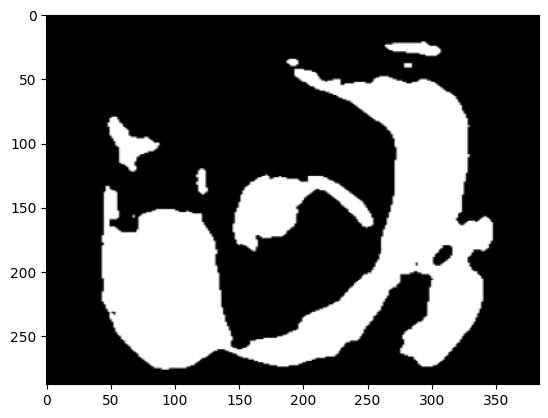

In [ ]:
mask = mask[-1]

# Convert torch tensor to numpy array
mask = mask.detach().cpu().numpy()

# Convert output to a 2-d array
mask = np.squeeze(np.squeeze(mask, axis=0), axis=0)

# Convert output to binary based on threshold
mask[mask > -2.5] = 255
mask[mask <= -2.5] = 0

# Resize the ouptut image to input image size
mask = cv2.resize(mask, (im_width, im_height))

# Plot the generated mask
plt.imshow(mask, cmap="gray")

## Read and plot the ground truth mask

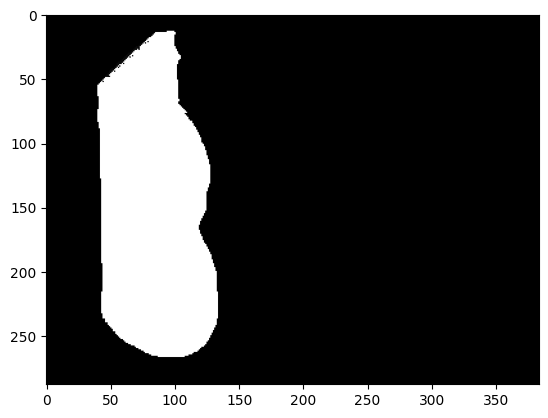

In [ ]:
actual_mask = "/content/drive/MyDrive/IzhanResearch/GroundTruth/10.png"
am = plt.imread(actual_mask)
plt.imshow(am, cmap="gray")